In [303]:
import pandas as pd
import numpy as np
import mysql.connector

In [304]:
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

dpd vs. ratio
<img src="dpd v. ratio.png">
total amount vs. ratio
<img src="total amount vs. ratio.png">
dpd vs. difference
<img src="dpd vs. difference.png">
total amount vs. difference
<img src="total vs. difference.png">
trained on 1000 examples
<img src="1k.png">
trained on 10k examples
<img src="10k.png">

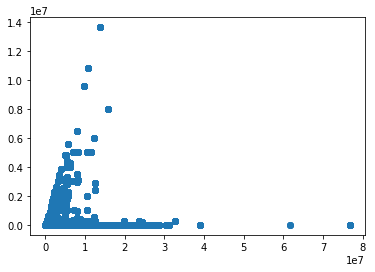

     outlet_code  cash_memo_total_amount  ratio_total_per_balance  \
0          97437               2049284.0                 155127.0   
1          96858              10404232.0                      0.0   
2          97492               4718250.0                 150000.0   
3          97492               4718250.0                 150000.0   
4          97492               4718250.0                 150000.0   
5          97492               4718250.0                 150000.0   
6          97492               5524853.0                      0.0   
7          97492               5524853.0                      0.0   
8          96787               2697324.0                  49029.0   
9          96696               2335810.0                      0.0   
10         96537               2645629.0                      0.0   
11         96787               1369748.0                      0.0   
12         96505               1263671.0                      0.0   
13         96491               433

In [312]:
hp_limit = 1000
train_limit = 10000
output = "ratio_total_per_balance"

df = pd.read_csv('data_invoce_topan.csv')

df["ratio_total_per_balance"] = df["cash_memo_total_amount"] - df["cash_memo_balance_amount"]
#df["ratio_total_per_balance"] =  df["cash_memo_total_amount"] - df["cash_memo_balance_amount"]

#plt.plot(df["DPD"], df["ratio_total_per_balance"], linestyle="None", marker='o')
plt.plot(df["cash_memo_total_amount"], df["ratio_total_per_balance"], linestyle="None", marker='o')
plt.show()

df = df.drop("cash_memo_balance_amount", axis=1)

df_part = df[:hp_limit]

print(df_part)

train_set, test_set = train_test_split(df_part, test_size=0.2)

train_labels = train_set[output].copy()
train_features = train_set.drop(output, axis=1)

test_labels = test_set[output].copy()
test_features = test_set.drop(output, axis=1)



In [306]:
"""from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attibute_names):
        self.attibute_names = attibute_names
    def fit(self, X, y=None):
        return(self)
    def transform(self, X): 
        return(X[self.attibute_names].values)

#%run CategoricalEncoder.py

cat_attributes = ['outlet_code']
num_attributes = ['DPD','product_price','ratio_total_per_balance']

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
#     ('imputer',Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('label_binarizer',CategoricalEncoder(encoding="onehot-dense")),])

full_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline',cat_pipeline),
    ('num_pipeline',num_pipeline),])

df_prepared = full_pipeline.fit_transform(train_set.copy())
df_labels = train_set[output].copy()
df_prepared.shape"""

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
def evaluate(labels, predictions):
    #Begin rms error
    rmse_accuracy = 100 - np.sqrt(mean_squared_error(labels, predictions))/(np.amax(labels) - np.amin(labels)) * 100

    errors = abs(predictions - labels) # this was one way I found in "towards data science" website, we can use the NRMSD 
                                        # to calculate the error. 
    mape = 100 * (errors / test_labels)  # Calculate mean absolute percentage error (MAPE)
    #print(mape)
    mape_accuracy = 100 - np.mean(mape) # Calculate and display accuracy
    plt.plot(labels, predictions)
    plt.show()
    accuracy_grid = {"RMSE Percentage Accuracy": rmse_accuracy, "r2 score /1":r2_score(labels, predictions)}
    return accuracy_grid

In [307]:
"""from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

df_test_labels = test_set[output]

df_test = full_pipeline.transform(test_set)

predictions = lin_reg.predict(df_test)

print(str(evaluate(df_test_labels, predictions)) + ' normalized percent error')
compare = {'predicted':list(predictions),'examples':list(df_test_labels)}
pd.DataFrame(compare)
"""


"from sklearn.linear_model import LinearRegression\n\nlin_reg = LinearRegression()\nlin_reg.fit(df_prepared, df_labels)\n\ndf_test_labels = test_set[output]\n\ndf_test = full_pipeline.transform(test_set)\n\npredictions = lin_reg.predict(df_test)\n\nprint(str(evaluate(df_test_labels, predictions)) + ' normalized percent error')\ncompare = {'predicted':list(predictions),'examples':list(df_test_labels)}\npd.DataFrame(compare)\n"

In [308]:
"""https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 """

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

def RandomCVTuningRandomForest(train_features, train_labels):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 600, stop = 1600, num = 3)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(train_features, train_labels)
    print(rf_random.best_params_)
    return rf_random

hp_result = RandomCVTuningRandomForest(train_features, train_labels)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimator

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.7s


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   2.3s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   4.1s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.0s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.0s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=600,

[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False, total=   4.9s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False, total=   5.3s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False, total=   5.3s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False, total=   5.2s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   3.1s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   3.0s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   3.2s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   2.2s
[CV] n_estimators=1

[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=   2.4s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=   2.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=   2.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   1.9s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=600, m

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min


[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=   4.9s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   2.4s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   2.4s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total=   2.4s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=1100,

[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   3.8s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   4.0s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   3.9s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=   4.3s
[CV] n_estimators=600, m

[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=False, total=   2.9s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   5.6s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   2.2s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=600, min_sa

[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=False, total=   3.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, total=   2.9s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   2.6s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   2.6s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, m

[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   4.4s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   4.4s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=False, total=   3.0s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   1.9s
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}


<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>


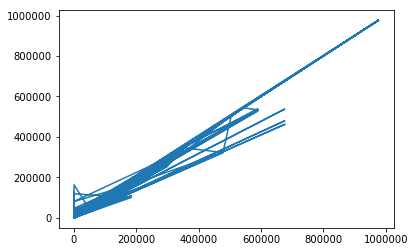

{'RMSE Percentage Accuracy': 98.548986614051501, 'r2 score /1': 0.98897654643728139}


In [309]:
#print(Predictor.predict(test_features))
df_full = df[hp_limit:hp_limit+train_limit]
train_set, test_set = train_test_split(df_full, test_size=0.2)

train_labels = train_set[output].copy()
train_features = train_set.drop(output, axis=1)

test_labels = test_set[output].copy()
test_features = test_set.drop(output, axis=1)

Predictor = hp_result.best_estimator_

print(type(train_labels), type(train_features))

Predictor.fit(train_features, train_labels)

print(evaluate(test_labels, Predictor.predict(test_features)))


In [310]:
import ipywidgets as widgets
from IPython.display import display, Image
from ipywidgets import HBox, Label
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# w = widgets.IntSlider()
# display(w)
IntSliderlayout = widgets.Layout(width='70%', height='50px') # the layout that contains the intSlider

outlet_code_Textwidget = widgets.Text(
#     description = 'outlet_code',
#     layout=widgets.Layout(width='50%', height='80px')
)
outletBox = HBox([Label('outlet code'), outlet_code_Textwidget]) # a box tha holds the outlet code text box. This is used with this widget
                                                     # and other widgets to allow for more room for the label as description
                                                     # doesn't scale properly in size.
cash_memo_total_amount_Textwidget = widgets.Text(
#     description = 'cash_memo_balance_amount'
)
cash_memo_total_amountBox = HBox([Label('cash memo total amount'), cash_memo_total_amount_Textwidget])

# cash_memo_total_amount_Textwidget = widgets.Text()
# cash_memo_total_amountBox = HBox([Label('cash memo total amount'), cash_memo_total_amount_Textwidget])

product_price_Textwidget = widgets.Text(
#     description = 'product_price'
)
product_priceBox = HBox([Label('product price'), product_price_Textwidget])

quantity_Textwidget = widgets.Text(
#     description = 'quantity'
)
quantityBox = HBox([Label('quantity'), quantity_Textwidget])

DPD_IntSliderwidget = widgets.IntSlider(
    value = 0, # the initial value
    min = 0,  # setting the min and max values of the slider
    max = 30,    
#     description='DPD:', # a text describing the slider
    disabled=False, # if you want to disable the slider or enable it.
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout = IntSliderlayout,
    readout_format='d'
)
DPDBox = HBox([Label('DPD (max value = 30, min value = 0)'), DPD_IntSliderwidget])

submit_button = widgets.Button(
    description = 'submit features'
)

ratiopaidLabel = Label(
)

# defining and setting up the image widget
imgFile = open("logo.png", "rb")
image = imgFile.read()
imageWidget = widgets.Image(
    value=image,
    format='png',
    width=500,
    height=110,
)

# the method that used in the submit button click event
def submitFeatures(btn_object):
    
    outlet_code = int(outlet_code_Textwidget.value)
    cash_memo_total = float(cash_memo_total_amount_Textwidget.value)
    productprice = float(product_price_Textwidget.value)
    quantity = int(quantity_Textwidget.value)
    dpd = int(DPD_IntSliderwidget.value)
    
    predictor_input = [[outlet_code,
                               cash_memo_total,
                                productprice,
                                quantity,
                                dpd
                               ]]
    
    print(predictor_input)
    
    prediction = Predictor.predict(predictor_input)
    prediction = str(prediction[0])
    
    print('outlet: ', outlet_code_Textwidget.value)
    print('amountDue: ', cash_memo_total_amount_Textwidget.value)
    print('productPrice: ', product_price_Textwidget.value)
    print('DPD: ', DPD_IntSliderwidget.value)
    print('quantity: ', quantity_Textwidget.value)
    print('cash_memo_total_amount: ', cash_memo_total_amount_Textwidget.value)
    print('ratio: ', prediction)
    
    ratiopaidLabel.description = prediction
    display( Label(prediction) )
    
  # storing the result of the final quantity value here
#     print('-- prediction of ratio paid ', prediction)

display(imageWidget) # showing the image 
display(outletBox) # showing the outlet text field widget
display(cash_memo_total_amountBox) # showing the cash_memo_balance text field widget
display(product_priceBox) #  showing the product_price text field widget
display(DPDBox) #  showing the DPD slider widget
# display(cash_memo_total_amountBox) #  showing the cash_memo_total text field widget
display(quantityBox)
display(submit_button) #  showing the submit button widget
submit_button.on_click(submitFeatures)

display(Label('the Paid Ratio based on the features is: '))  # showing the quantity label 

display(ratiopaidLabel) # showing the quantity label result 
# w.close()

[[97492, 5039493.0, 495939.0, 20, 0]]
outlet:  97492
amountDue:  5039493
productPrice:  495939
DPD:  0
quantity:  20
cash_memo_total_amount:  5039493
ratio:  236183.86


[[97492, 5039493.0, 495939.0, 20, 4]]
outlet:  97492
amountDue:  5039493
productPrice:  495939
DPD:  4
quantity:  20
cash_memo_total_amount:  5039493
ratio:  82567.741875


[[97492, 5039493.0, 495939.0, 20, 16]]
outlet:  97492
amountDue:  5039493
productPrice:  495939
DPD:  16
quantity:  20
cash_memo_total_amount:  5039493
ratio:  103905.650625


[[97492, 5039493.0, 495939.0, 20, 21]]
outlet:  97492
amountDue:  5039493
productPrice:  495939
DPD:  21
quantity:  20
cash_memo_total_amount:  5039493
ratio:  103905.650625
